## Data
The animal audiograms database contains [10 audiograms](https://animalaudiograms.museumfuernaturkunde.berlin/audiogram?ids=31,32,63,61,60,58,65,64,62,57) of orcas in water.

All the audiograms for orcas were downloaded and stored in the file `data/Orcinus_orca.csv` (downloading data for compound queries is an experimental feature that is not yet available on the public relase of the database). The data can now be loaded and a compound audiogram can be calculated by applying a fit function.

The audiogram will be used to construct a filter. The filter will be applied on recording with a sapling rate up to 48kHz. Therefore, only the frequency range between 20Hz and 24kHz is pertinent for this task.

In [1]:
# import the FFT scripts from local file FFT.R
source("FFT.R")

# Read the downloaded data
data_file <- "./data/Orcinus_orca.csv"
audiogram <- read.table(data_file, header=TRUE, sep=",")

## Defining the filter values
The filter is constructed based on the audiogram:
* As the recordings' sample rate tops at 48 kHz, the highest filter band is 24 kHz. The lowest filter band is at 20Hz, which is a realistic lower limit for a recording.
* For each EQ band, the audiogram value corresponding to the EQ band is computed by interpolating the audiogram data using a fit function ([loess](https://www.rdocumentation.org/packages/stats/versions/3.6.2/topics/loess))
* Values outside the measurements in the audiogram have to be extrapolated to construct the filter (otherwise they would not be filtered)
* Equalization steps are spaced in 1 octave intervals (there are 10 octaves between 20Hz and 24kHz)
* For each EQ step, the filter gain is calculated relatively to the best overall hearing performance in the audiogram
* A bass cutoff is applied at the end (-20dB) to remove frequencies which are lower than the lowest EQ band (20Hz).

The filter is then implemented as a [sox](http://sox.sourceforge.net/) command.

In [2]:
filter.table <- def_filter(audiogram)
filter.table

Frequency.in.kHz,Gain.in.dB
<dbl>,<dbl>
0.020,-57
0.044,-56
0.097,-56
0.213,-56
0.467,-54
1.027,-52
2.258,-47
4.965,-36
10.916,-17


## Implement the filter
Implement a filter using the values from table above. Q is set to 0.7 (almost 2 octaves) for a smoother filter curve.

The generated command can be used to invoque sox by copy-pasting it in a Linux terminal.

In [3]:
# sox command
inputfile <- "data/whitenoise.wav"
outputfile <- "data/ft_Orcinus_orca.wav"
Q <- 0.7
command <- sox_command(inputfile, outputfile, filter.table, Q)
command

[1] "sox data/whitenoise.wav data/ft_Orcinus_orca.wav equalizer 20 0.7 -28.5 equalizer 44 0.7 -28 equalizer 97 0.7 -28 equalizer 213 0.7 -28 equalizer 467 0.7 -27 equalizer 1027 0.7 -26 equalizer 2258 0.7 -23.5 equalizer 4965 0.7 -18 equalizer 10916 0.7 -8.5 equalizer 24000 0.7 0 bass -20"

## Testing the filter
The filter was tested by applying it to a file containing 1 second of white noise. The result can be checked visually in the following FFT plots.

Generate white noise and save it to file
`sox -n data/whitenoise.wav synth 1 whitenoise`

Warning message:
“Removed 20 rows containing missing values (geom_path).”


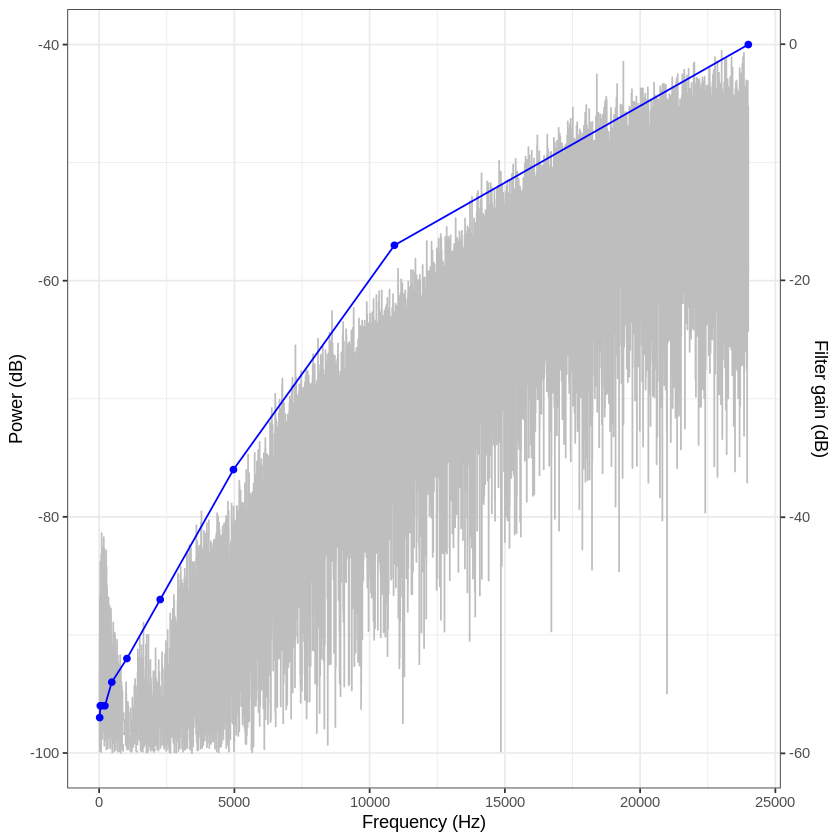

In [4]:
# compute FFT for the input file
sndObj <- readWave(outputfile)
fft <- comp_fft(sndObj)

# plot the filtered data and the filter values
plot_filter_fft(fft, filter.table)


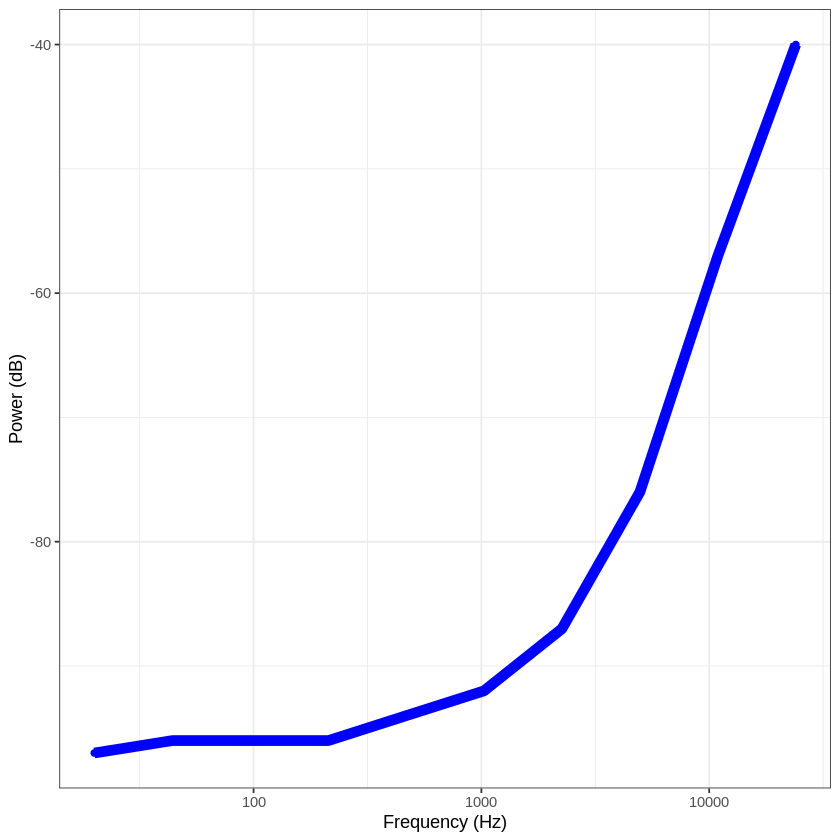

In [4]:
# plot the filter values
ggplot() +
    geom_line(data=filter.table, aes(Frequency.in.kHz*1000, Gain.in.dB-40), color="blue", size=3) +
    geom_point(data=filter.table, aes(Frequency.in.kHz*1000, Gain.in.dB-40), color="blue") +
    labs(x = "Frequency (Hz)", y = "Power (dB)") +
    scale_y_continuous() +
    scale_x_log10(limits=c(20, 24000)) +
    theme_bw()